In [1]:
from os.path import join
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from growth.sweep.sweep import Sweep
from clones.visualization.settings import *
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from clones.annotation.spatial import WeightedGraph
from clones.annotation.spatial.sampling import SpatialSampler
from clones.annotation.annotation import MixtureModelAnnotation, DiffusionAnnotation

In [3]:
def score(x, y):
    """ Returns fraction of labels that are the same. """
    return (x==y).sum()/x.size

# Generate synthetic data

Load simulated bleedthrough control experiment and generate synthetic fluorescence data. Synthetic images contain three color channels:
   - BLUE: Nuclear stain
   - RED: Clonal marker
   - GREEN: Control reporter

In [55]:
ambiguity = 1.

sweep = Sweep.load('../../../data/synthetic/sweeps/Sweep_181201_191516/')
simulation = sweep[0]

measurement_kwargs = dict(measurement_noise=0.)
microscopy_kwargs = dict(bg_level=0.2, bg_noise=0.3)

microscopy = simulation.generate_microscopy(ambiguity=ambiguity, rho=0.0, bleedthrough=0.5, 
                measurement_kwargs=measurement_kwargs, microscopy_kwargs=microscopy_kwargs)

data = microscopy.data

In [56]:
attr = 'clonal_marker'
graph = WeightedGraph(data, attr)

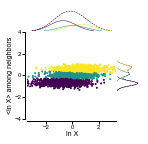

In [90]:
training_depth = 3
annotator = MixtureModelAnnotation('clonal_marker', min_num_components=3, max_num_components=3, depth=training_depth)
selector = annotator.train(graph)
#_ = selector.plot_information_criteria()
_ = annotator.classifier.plot_bivariate_data(s=1)

In [91]:
# generate test data
test_depth = 1
test_values = np.log(SpatialSampler(graph, 'clonal_marker', depth=test_depth).sample)

In [92]:
# ground truth
ground_truth = graph.df.true_dosage.values

# pure annotation
mixture_labels = annotator.annotate(graph, resample=True, depth=test_depth)

# diffusion-based annotation
diffusion_annotator = DiffusionAnnotation.copy(annotator)
diffusion_labels = diffusion_annotator.annotate(graph, resample=True, depth=test_depth)
posteriors = annotator.classifier.posterior(test_values)

# evaluate marginal posteriors
x_posteriors = annotator.classifier[0].posterior(test_values[:, [0]])
y_posteriors = annotator.classifier[1].posterior(test_values[:, [1]])
x_labels = x_posteriors.argmax(axis=1)

# mix univariate and multivariate classifier results
threshold = 0.8
hybrid_posteriors = deepcopy(x_posteriors)
mask = np.logical_and(posteriors.max(axis=1) > threshold, x_posteriors.max(axis=1) < threshold)
hybrid_posteriors[mask, :] = posteriors[mask, :]
hybrid_labels = hybrid_posteriors.argmax(axis=1)

# diffuse hybrid posteriors
diffused_hybrid_posteriors = DiffusionAnnotation.diffuse_posteriors(graph, hybrid_posteriors, alpha=.9)
diffused_hybrid_labels = diffused_hybrid_posteriors.argmax(axis=1)

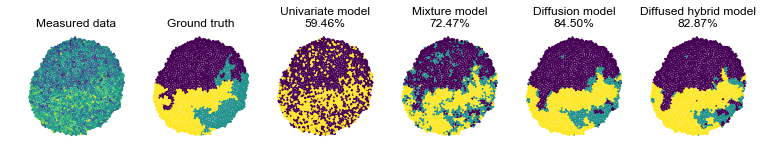

In [93]:
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(ncols=6, figsize=(13,3))

ax0.scatter(graph.df.centroid_x, graph.df.centroid_y, c=np.log(graph.df.clonal_marker), s=2)
ax0.set_title('Measured data')

ax1.scatter(graph.df.centroid_x, graph.df.centroid_y, c=graph.df.true_dosage, s=2)
ax1.set_title('Ground truth')

ax2.scatter(graph.df.centroid_x, graph.df.centroid_y, c=x_labels, s=2)
ax2.set_title('Univariate model\n{:0.2%}'.format(score(ground_truth, x_labels)))

ax3.scatter(graph.df.centroid_x, graph.df.centroid_y, c=mixture_labels, s=2)
ax3.set_title('Mixture model\n{:0.2%}'.format(score(ground_truth, mixture_labels)))

ax4.scatter(graph.df.centroid_x, graph.df.centroid_y, c=diffusion_labels, s=2)
ax4.set_title('Diffusion model\n{:0.2%}'.format(score(ground_truth, diffusion_labels)))

ax5.scatter(graph.df.centroid_x, graph.df.centroid_y, c=diffused_hybrid_labels, s=2)
ax5.set_title('Diffused hybrid model\n{:0.2%}'.format(score(ground_truth, diffused_hybrid_labels)))

for ax in (ax0, ax1, ax2, ax3, ax4, ax5):
    ax.axis('off')
    ax.set_aspect(1)

# Infomap

Applying classifier to local average within community.

In [38]:
graph.find_communities(twolevel=True)
community_levels = graph.df.groupby('community')['clonal_marker'].aggregate(lambda x: np.log(x).mean())
community_to_mean_level = np.vectorize(dict(community_levels).get)
local_average_levels = community_to_mean_level(graph.df.community.values)
levels = np.log(graph.df.clonal_marker.values)
community_sample = np.vstack((levels, local_average_levels)).T

In [40]:
community_posterior = annotator.classifier.posterior(community_sample)
adjacency = graph.adjacency_positional
community_diffused_posterior = diffuse_posteriors(community_posterior, adjacency, alpha=0.9)

NameError: name 'diffuse_posteriors' is not defined

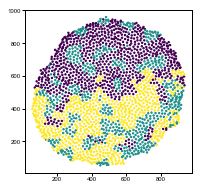

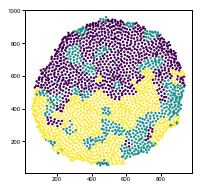

In [257]:
fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(graph.df.centroid_x, graph.df.centroid_y, c=community_posterior.argmax(axis=1), s=2)

fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(graph.df.centroid_x, graph.df.centroid_y, c=community_diffused_posterior.argmax(axis=1), s=2)

In [ ]:

def get_posterior(self, graph, depth=None, resample=False):
    
    if depth is None:
        depth = self.depth

    # check if sample already exists
    if resample:
        sampler = SpatialSampler(graph, self.attribute, depth=depth)
        sample = sampler.sample
    else: 
        sample = graph.df[self.keys].values

    if self.classifier.log:
        sample = np.log(sample)

    # evaluate posterior label distribution for each node
    posterior = self.classifier.posterior(sample)
    
    return posterior

def get_adjacency(graph, order_by_position=True):
    adjacency = nx.to_numpy_array(graph.get_networkx(), nodelist=graph.nodes)
    
    if order_by_position:
        sort_ind = np.argsort(graph.position_map(graph.nodes))
        adjacency = adjacency[sort_ind, :][:, sort_ind]
    
    adjacency /= adjacency.sum(axis=0)
    return adjacency

def diffuse_posteriors(posterior, adjacency, alpha=0.9):

    n = np.array(adjacency).shape[0]
    external = np.eye(n, n) - (alpha * adjacency)
    internal = (1 - alpha) * posterior
    diffused_posteriors = np.linalg.solve(external, internal)

    return diffused_posteriors

def score(x, y):
    mae = np.abs(x-y).mean()
    pct = (x==y).sum()/x.size
    return mae, pct

def pct_error(x, y):
    pct = (x==y).sum()/x.size
    return pct

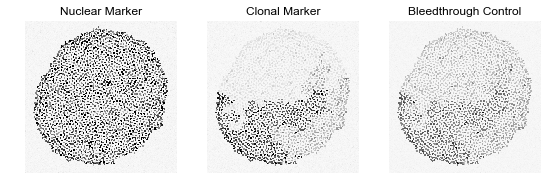

In [5]:
nuclear_marker = microscopy[0]
clonal_marker = microscopy[1]
control_reporter = microscopy[2]

fig = microscopy.render_panels(size=3)


import scipy.stats as st
def jensen_shannon_distance(x, y):
    """ Returns Jensen-Shannon distance between <x> and <y>. """
    return np.sqrt(0.5*(st.entropy(x, y, base=2)+st.entropy(y, x, base=2)))